In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.neural_network import MLPRegressor

In [25]:
jester_ratings = pd.read_excel("jester-data-1.xls", header=None)
# remove jokes rated num and replace 99 (not rated) with nan
jester_ratings = jester_ratings.iloc[:, 1:].replace(99, float('nan'))
# get means for each joke
ratings_mean = jester_ratings.mean()

In [50]:
best_joke = ratings_mean.idxmax()
worst_joke = ratings_mean.idxmin()
print(best_joke)
print(worst_joke)

50
58


In [52]:
jester_jokes = []
for i in range(1, 101):
    file_name = f'jokes/init{i}.html'
    with open(file_name, 'r') as file:
        joke_html = file.read()
        soup = BeautifulSoup(joke_html, 'html.parser')
        joke_text = soup.find('font', size='+1').text.strip()
        jester_jokes.append(joke_text)

In [27]:
embeddings = SentenceTransformer("bert-base-cased").encode(jester_jokes)

No sentence-transformers model found with name /home/qriaa/.cache/torch/sentence_transformers/bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/qriaa/.cache/torch/sentence_transformers/bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod

In [30]:
train_X, test_X, train_y, test_y = train_test_split(
    embeddings, 
    ratings_mean, 
    test_size=0.2, 
    random_state=1)

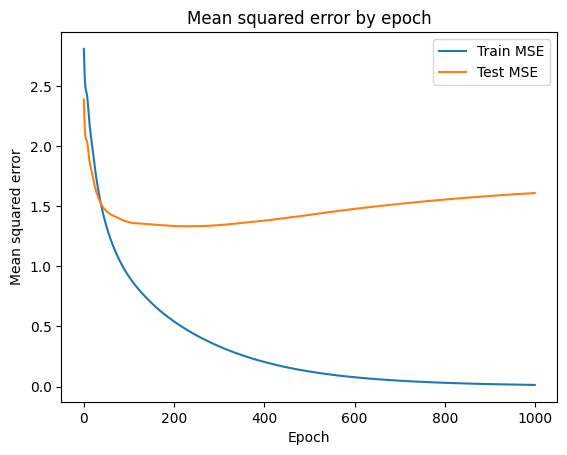

In [41]:
def run_model(epochs, learning_rate) -> tuple:
    model = MLPRegressor(solver="sgd",
                        alpha=0.0,
                        learning_rate="constant",
                        learning_rate_init=learning_rate)

    train_mse = []
    test_mse = []
    for _ in range(epochs):
        model.partial_fit(train_X, train_y)
        pred_train = model.predict(train_X)
        train_mse.append(mean_squared_error(train_y, pred_train))

        pred_test = model.predict(test_X)
        test_mse.append(mean_squared_error(test_y, pred_test))
    return model, train_mse, test_mse

_, train, test = run_model(1000, 0.001)

plt.plot(train, label="Train MSE")
plt.plot(test, label="Test MSE")
plt.title("Mean squared error by epoch")
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.legend()
plt.show()

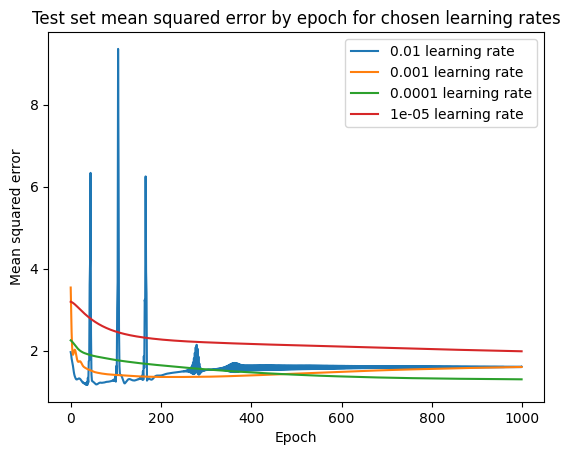

In [43]:
learning_rates = [0.01, 0.001, 0.0001, 0.00001]
for rate in learning_rates:
    _, train, test = run_model(1000, rate)
    plt.plot(test, label = f"{rate} learning rate")
plt.legend()
plt.title("Test set mean squared error by epoch for chosen learning rates")
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

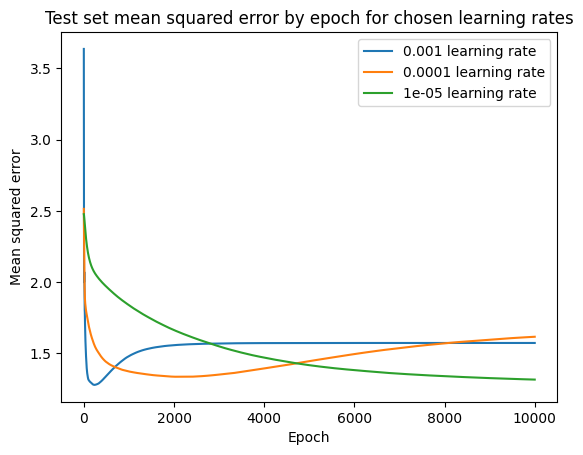

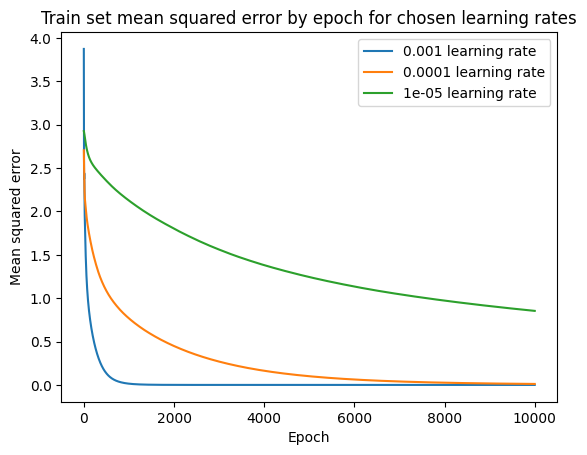

In [46]:
learning_rates = [0.001, 0.0001, 0.00001]
train_results = []
test_results = []
for rate in learning_rates:
    _, train, test = run_model(10000, rate)
    train_results.append((train, rate))
    test_results.append((test, rate))


for test, rate in test_results:
    plt.plot(test, label = f"{rate} learning rate")

plt.legend()
plt.title("Test set mean squared error by epoch for chosen learning rates")
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

for train, rate in train_results:
    plt.plot(train, label = f"{rate} learning rate")

plt.legend()
plt.title("Train set mean squared error by epoch for chosen learning rates")
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()
